# Minimal Example of using a pretrained Binary Model for Inference

This notebook gives a minimal example on how to use the pretrained binary models from Bitorch. It optionally also allows the conversion into a binarized inference mode using `bitorch_engine`.



In [1]:
from bitorch.models import ResnetE18
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from pathlib import Path
import matplotlib.pyplot as plt
import time
import random
import json
import numpy as np
from PIL import Image
import os
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = Path("data")
data_path.mkdir(parents=True, exist_ok=True)

/home/paul/uni/deeplearning/bitorch/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### loading an example image

The code below downloads an example image from the ImageNet dataset and the dictionary to map predicted indices back to class names.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Using downloaded and verified file: data/n01443537_goldfish.JPEG
Using downloaded and verified file: data/class_dict.json


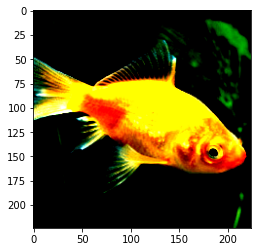

In [2]:
def show_picture(picture):
    plt.imshow(np.transpose(picture, (1, 2, 0)))
    plt.show()

image_download_url = "https://github.com/EliSchwartz/imagenet-sample-images/raw/master/n01443537_goldfish.JPEG"
class_dict_download_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

image_net_mean = (0.485, 0.456, 0.406)
image_net_std_dev = (0.229, 0.224, 0.255)
image_net_shape = (1, 3, 224, 224)

image_file_name = image_download_url.split("/")[-1]

download_url(image_download_url, data_path, image_file_name)
download_url(class_dict_download_url, data_path, "class_dict.json")

image = Image.open(data_path / image_file_name)
transformed_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(image_net_mean, image_net_std_dev),
])(image)

with (data_path / "class_dict.json").open("r") as f:
    class_dict = json.load(f)


show_picture(transformed_image.cpu().numpy())

### Loading the pretrained model from the model hub

Below code just loads the model.

In [3]:
model = ResnetE18.from_pretrained(input_shape=image_net_shape, num_classes=1000)
model = model.to(device)
model.eval()
print("model successfully loaded from hub!")

Using downloaded and verified file: /tmp/bitorch_model_version_table.csv
model successfully loaded from hub!


### (Optional:) Speed up model inference by converting it to a different runtime mode

In [4]:
# from bitorch.layers import convert
# from bitorch import RuntimeMode
# import bitorch_engine

# bitorch_engine.initialize()

# model = convert(model, RuntimeMode.INFERENCE_AUTO, device=device, verbose=True)

### Predict a class for the given image

In the cell below the model predicts the class of the downloaded example image. It then shows the models top 5 predictions.

In [5]:

classes_to_show = 5

inference_image = transformed_image.unsqueeze(0).to(device)
print(f"Input shape: {inference_image.shape}")

start = time.time()
prediction = model(inference_image)
duration = time.time() - start

print(f"Output shape: {prediction.shape}")

prediction = torch.nn.functional.softmax(prediction, dim=1)

top_class_probs, top_class_indices = torch.topk(prediction, classes_to_show, dim=1)
top_class_indices = top_class_indices[0].cpu().detach().numpy()
top_class_probs = top_class_probs[0].cpu().detach().numpy()
top_classes = [(class_dict[str(class_id)][1], probability) for probability, class_id in zip(top_class_probs, top_class_indices)]

print(f"Prediction: {top_classes} (took {duration:.2f} seconds)")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1000])
Prediction: [('goldfish', 0.52404714), ('tench', 0.13652243), ('puffer', 0.057238027), ("yellow_lady's_slipper", 0.0137333535), ('eel', 0.010772856)] (took 0.02 seconds)
